In [1]:
import pandas as pd 
import numpy as np
import pandas_datareader as pdr 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pickle
import itertools
pd.options.display.float_format = '{:,.2f}'.format

C:\Users\Momir\.conda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%store -r vix_daily

## Individual Stock Data

In [3]:
df = pd.read_excel('Data//df_371.xlsx')
df = df.set_index('Date')
df_CCR = (np.log(df)-np.log(df.shift(1)))[1:]
df_CCR = df_CCR[df_CCR.index.year<2020]

## Loading Portfolio Weights

In [4]:
pickle_in = open('sample370.pickle', 'rb')
sample370 = pickle.load(pickle_in)
pickle_in = open('regular.pickle', 'rb')
w_regular = pickle.load(pickle_in)

In [5]:
Portfolios = ['1/N', 'hist', 'hist_C', 'part_imp', 'zero', 'LW', 'JM']

## Grouping Weights Per Samples

In [6]:
w_0 = {}
w_1 = {}
w_2 = {}
w_3 = {}
w_4 = {}
w_5 = {}
w_etf1 = {}
w_etf2 = {}
for i in range(len(Portfolios)):
    w_0[i] = w_regular[i][0]
    w_1[i] = w_regular[i][1]
    w_2[i] = w_regular[i][2]
    w_3[i] = w_regular[i][3]
    w_4[i] = w_regular[i][4]
    w_5[i] = w_regular[i][5]
    w_etf1[i] = w_regular[i][6]
    w_etf2[i] = w_regular[i][7]
        
    
w = [w_0, w_1, w_2, w_3, w_4, w_5, sample370, w_etf1, w_etf2]
weights = {}
for i in range(len(w)):
    weights[i] = w[i]

In [7]:
titles = ['S_19', 'S_50A', 'S_50B', 'S_50C', 'S_150A', 'S_150B', 'S_370', 'sectors', 'iShares']

In [8]:
print ('First [] - choose sample (0, 1, 2, 3, 4, 5, 6) which represent (sample_19, sample_50A, sample_50B, sample_50C, sample_150A, sample_150B, sample_370) samples, respectively.')
print ('Second [] - choose portfolio (0, 1, 2, 3, 4) which stand for (1/N, min_v_H, min_v_H_NS, min_v_MM, min_v_Zero_MM) portfolios, respectively.')
print ('Third [] - choose interval, 0 to 238')
print ('----------------------------------')
print ('weights[sample][portfolio][interval]')

First [] - choose sample (0, 1, 2, 3, 4, 5, 6) which represent (sample_19, sample_50A, sample_50B, sample_50C, sample_150A, sample_150B, sample_370) samples, respectively.
Second [] - choose portfolio (0, 1, 2, 3, 4) which stand for (1/N, min_v_H, min_v_H_NS, min_v_MM, min_v_Zero_MM) portfolios, respectively.
Third [] - choose interval, 0 to 238
----------------------------------
weights[sample][portfolio][interval]


In [9]:
gspc = df_CCR[df_CCR.columns[-1]]

## Preparing Backtesting Data Per Samples

In [10]:
%store -r samples

data = {}
for j in range (len(samples)):
    bln = []
    for i in range (len(df_CCR.columns)):
        if np.asarray([df_CCR.columns[i] == samples[j][z] for z in range (len(samples[j]))]).any() == True:
            bln.append (np.bool(1))
        else:
            bln.append(np.bool(0))
    data[j] = df_CCR[df_CCR.columns[bln]]  

In [11]:
print ([len(data[i].columns) for i in range (len(data))])

[20, 51, 51, 51, 151, 151, 371, 1, 1]


## Adding ETF Samples

In [12]:
df_ETF = pd.read_excel('Data//ETF_sample.xlsx')
df_ETF = df_ETF.set_index('Date')
df_CCR_ETF = (np.log(df_ETF)-np.log(df_ETF.shift(1)))[1:]
df_CCR_ETF = df_CCR_ETF[df_CCR_ETF.index.year<2020]

df_ETF1 = pd.read_excel('Data//iShares_etfs.xlsx')
df_ETF1 = df_ETF1.set_index('Date')
df_CCR_ETF1 = (np.log(df_ETF1)-np.log(df_ETF1.shift(1)))[1:]
df_CCR_ETF1 = df_CCR_ETF1[df_CCR_ETF1.index.year<2020]

In [13]:
data[7] = df_CCR_ETF
data[8] = df_CCR_ETF1

print ([len(data[i].columns) for i in range (len(data))])

[20, 51, 51, 51, 151, 151, 371, 13, 30]


## Starting Dates of Rebalancing Intervals

In [14]:
starts = [dt.datetime(2000, 2, 1), dt.datetime(2000, 2, 1), dt.datetime(2000, 2, 1), dt.datetime(2000, 2, 1), dt.datetime(2000, 2, 1), dt.datetime(2000, 2, 1), 
        dt.datetime(2000, 2, 1), dt.datetime(2003, 1, 2), dt.datetime(2002, 1, 2)]
len(starts)

9

In [15]:
delta = 21
starting_dates = {}
for i in range(len(data)):
    total=0
    dates = []
    while total<len(data[i][data[i].index>starts[i]]):
        dates.append(data[i].index[int(np.argwhere(data[i].index==starts[i]))+total])
        total+=delta
    starting_dates[i] = pd.to_datetime(dates)    

## Generating Daily Portfolio Return For Each Strategy Under Consideration

In [16]:
def backtest (weights, Portfolios, df_CCR, starting_dates):
    
    """""
    weights - dictionary containing weights for each rebalancing interval
    Portfolios - name of portfolio strategies, example: Portfolios = ['1/N', 'hist', 'hist_NS', 'ewma_implied', 'zero_ewma_implied']
    df_CCR - dataframe of log returns for each stock in the universe 
    starting_dates - rebalancing dates
    """""
    
    port_daily = pd.DataFrame(data=None, index = df_CCR.index[(df_CCR.index>=starting_dates[0]) * (df_CCR.index<starting_dates[-1])], columns = Portfolios)

    for n in range (len(weights)):
        weights[n] = dict(itertools.islice(weights[n].items(), len(starting_dates)-1)) #slice dictionary method, make sure all weights are the same lenghts

    out_of_sample = {}
    for number in range(len(starting_dates)-1):
        out_of_sample[number] = pd.DataFrame


    for i in range(len(starting_dates)-1):
        out_of_sample[i] = df_CCR[(df_CCR.index>=starting_dates[i]) * (df_CCR.index<starting_dates[i+1])]
        out_of_sample[i] = out_of_sample[i][df_CCR.columns[:-1]]

    total=0    
    for i in range(len(starting_dates)-1):
        for n in range (len(weights)):
            port_daily.iloc[total:total+21, [n]] = np.asarray (out_of_sample[i] @ weights[n][i])
        total+=21 
            
    return port_daily

port_daily = {}
for i in range (len(data)):
    port_daily[i] = backtest(weights[i], Portfolios, data[i], starting_dates[i])

## Computing Portfolios' Returns, Volatilities & Sharpes

In [17]:
def summary (port_daily, Portfolios):
    res = {}
    for i in range (len(port_daily)):
        
        Volatility = pd.Series(port_daily[i].std()*np.sqrt(252)*100)
        Return = pd.Series ((port_daily[i]).mean()*252*100)
        Sharpe_Ratio = Return/Volatility

        res[i] = Sharpe_Ratio, Return, Volatility

    
    Sharpes = pd.DataFrame (data = None, index = Portfolios, columns = titles)
    Returns = pd.DataFrame (data = None, index = Portfolios, columns = titles)
    Volatilities = pd.DataFrame (data = None, index = Portfolios, columns = titles)

    for i in range (len(res)):
        Sharpes.iloc[:, [i]] = np.asarray(res[i][0]).reshape((len(Portfolios), 1))
        Returns.iloc[:, [i]] = np.asarray(res[i][1]).reshape((len(Portfolios), 1))
        Volatilities.iloc[:, [i]] = np.asarray(res[i][2]).reshape((len(Portfolios), 1))
        
    return Sharpes, Returns, Volatilities

Sharpes = summary(port_daily, Portfolios)[0]
Returns = summary(port_daily, Portfolios)[1]
Volatilities = summary(port_daily, Portfolios)[2]
def highlight_max(x):
     #return ['font-weight: bold' if v == x.max() else ''for v in x]
    return ['background-color: yellow' if v == x.max() else ''for v in x]  
    
def highlight_min(x):
     #return ['font-weight: bold' if v == x.min() else ''for v in x]
    return ['background-color: yellow' if v == x.min() else ''for v in x]
    

In [18]:
print ("Panel A: Sharpe Ratio; Whole Period")
display (Sharpes.style.apply(highlight_max))
print ("Panel B: Annualized Return (%); Whole Period")
display (Returns.style.apply(highlight_max))
print('Panel C: Annualized Volatility (%); Whole Period')
display (Volatilities.style.apply(highlight_min))

Panel A: Sharpe Ratio; Whole Period


Panel B: Annualized Return (%); Whole Period


Panel C: Annualized Volatility (%); Whole Period


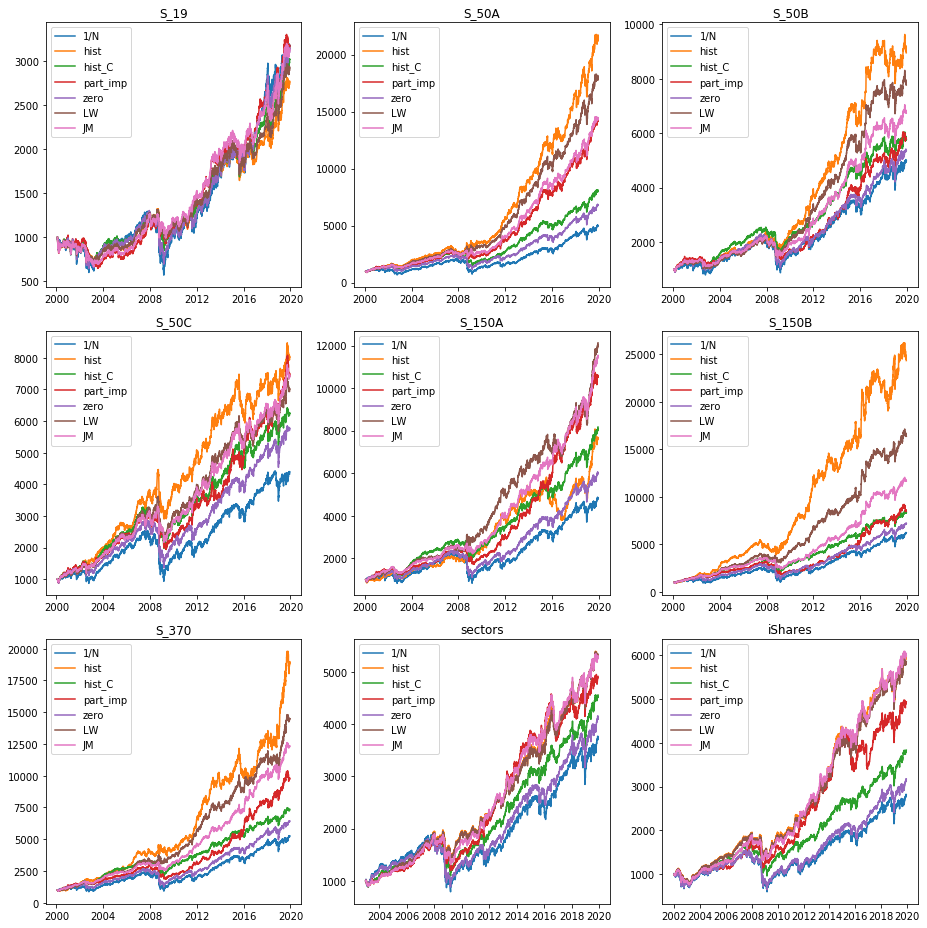

In [19]:
def group_plot (port_daily, save_as, fig_size = (13, 13), titles = titles):

    plot = {}
    for i in range(len(port_daily)):

        plottt = port_daily[i] + 1
        plottt[0:1] = 1000
        plot[i] = np.cumprod(plottt)

    fig, ax = plt.subplots(3, 3, figsize = fig_size)

    for i in range(3):
        for column in plot[i].columns:
            ax[0, i].plot(plot[i][column], label = column)
            ax[0, i].set_title(titles[i])
            ax[0, i].legend()

    for i in range(3):
        for column in plot[i+3].columns:
            ax[1, i].plot(plot[i+3][column], label = column)
            ax[1, i].set_title(titles[i+3])
            ax[1, i].legend()

    for i in range(3):
        for column in plot[i+6].columns:
            ax[2, i].plot(plot[i+6][column], label = column)
            ax[2, i].set_title(titles[i+6])
            ax[2, i].legend()


    plt.tight_layout()
    plt.savefig(save_as)
    plt.show()
    
group_plot (port_daily, 'Charts, Whole Period')

## Crisis vs Non Crisis Periods
### Crisis Intervals - Period by Period Analysis
To define crisis starting & ending dates we follow the report published by Yardeene Research where they identify two crisis and five market corrections in the 21st century. 

In [20]:
crisis_dates = [(dt.datetime(2000, 3, 31), dt.datetime(2002, 10, 9)), (dt.datetime(2002, 11, 27), dt.datetime(2003, 3, 11)), 
               (dt.datetime(2007, 10, 9), dt.datetime(2009, 3, 9)), (dt.datetime(2010, 4, 23), dt.datetime(2010, 7, 2)),
               (dt.datetime(2011, 4, 29), dt.datetime(2011, 10, 3)), (dt.datetime(2015, 5, 21), dt.datetime(2015, 8, 25)),
               (dt.datetime(2015, 11, 3), dt.datetime(2016, 2, 11))]

In [21]:
crisis = {}
for i in range(len(crisis_dates)):
    crisis[i] = starting_dates[0][(starting_dates[0]>crisis_dates[i][0])*(starting_dates[0]<crisis_dates[i][-1])]
    
bear_markets = []
for i in range(len(crisis)):
    bear_markets.append(crisis[i])
    
crisis_names = ['crisis1', 'correction1', 'crisis2', 'correction2', 'correction3', 'correction4', 'correction5']

In [22]:
def summary_intervals (port_daily, periods):

    sample = {}
    for i in range(len(port_daily)):
        res = {}
        for z in range (len(periods)):
            summary = port_daily[i][(port_daily[i].index>=periods[z][0])*(port_daily[i].index<=periods[z][-1])]
            Return = pd.Series (summary.mean()*252)
            Volatility = pd.Series (summary.std()) * np.sqrt(252)
            Sharpe_Ratio = Return/Volatility
            res[z] = Sharpe_Ratio, Return, Volatility  # len res = len crisis
        sample[i] = res  # sample[0][0][0] --> sample 0, crisis 0, Sharpe
                             
    
    
    crisis_res = {}
    Sharpes = {}
    Returns = {}
    Vol = {}
    for q in range(len(periods)):
        Sharpes[q] = pd.DataFrame (data = None, index = Portfolios, columns = titles)
        Returns[q] = pd.DataFrame (data = None, index = Portfolios, columns = titles)
        Vol[q] = pd.DataFrame (data = None, index = Portfolios, columns = titles)
    
        for i in range(len(sample)):
            Sharpes[q].iloc[:, [i]] = np.asarray (sample[i][q][0]).reshape((len(Portfolios), 1))
            Returns[q].iloc[:, [i]] = np.asarray (sample[i][q][1]*100).reshape((len(Portfolios), 1))
            Vol[q].iloc[:, [i]] = np.asarray (sample[i][q][2]*100).reshape((len(Portfolios), 1))
        
        crisis_res[q] = Sharpes[q], Returns[q], Vol[q]

    return crisis_res

In [23]:
test = summary_intervals(port_daily, bear_markets)

bear_market_names = ["March 2000 - October 2002", "November 2002 - March 2003", "October 2007 - March 2009", 
                     "April 2010 - July 2010", "April 2011 - October 2011", "May 2015 - August 2015",
                     "November 2015 - February 2016"]

for i in range(len(bear_market_names)):
    print (bear_market_names[i])
    print ("------------------------------------------------------------------")
    print("Panel A: Sharpe Ratio")
    display(test[i][0].style.apply(highlight_max))
    print ("Panel B: Annualized Return (%)")
    display(test[i][1].style.apply(highlight_max))
    print('Panel C: Annualized Volatility (%)')
    display(test[i][2].style.apply(highlight_min))

March 2000 - October 2002
------------------------------------------------------------------
Panel A: Sharpe Ratio


Panel B: Annualized Return (%)


Panel C: Annualized Volatility (%)


November 2002 - March 2003
------------------------------------------------------------------
Panel A: Sharpe Ratio


Panel B: Annualized Return (%)


Panel C: Annualized Volatility (%)


October 2007 - March 2009
------------------------------------------------------------------
Panel A: Sharpe Ratio


Panel B: Annualized Return (%)


Panel C: Annualized Volatility (%)


April 2010 - July 2010
------------------------------------------------------------------
Panel A: Sharpe Ratio


Panel B: Annualized Return (%)


Panel C: Annualized Volatility (%)


April 2011 - October 2011
------------------------------------------------------------------
Panel A: Sharpe Ratio


Panel B: Annualized Return (%)


Panel C: Annualized Volatility (%)


May 2015 - August 2015
------------------------------------------------------------------
Panel A: Sharpe Ratio


Panel B: Annualized Return (%)


Panel C: Annualized Volatility (%)


November 2015 - February 2016
------------------------------------------------------------------
Panel A: Sharpe Ratio


Panel B: Annualized Return (%)


Panel C: Annualized Volatility (%)


In [24]:
def group_plot_int(port_daily, start, end, save_as, fig_size = (13, 13), titles = titles):

    plot = {}
    for i in range(len(port_daily)):        
        plottt= port_daily[i][(port_daily[i].index>=start)*(port_daily[i].index<=end)] + 1
        plottt[0:1] = 1000
        plot[i] = np.cumprod(plottt)

    fig, ax = plt.subplots(3, 3, figsize = fig_size)

    for i in range(3):
        for column in plot[i].columns:
            ax[0, i].plot(plot[i][column], label = column)
            ax[0, i].set_title(titles[i])
            ax[0, i].legend()
            plt.setp(ax[0, i].get_xticklabels(), rotation=30, horizontalalignment='center')

    for i in range(3):
        for column in plot[i+3].columns:
            ax[1, i].plot(plot[i+3][column], label = column)
            ax[1, i].set_title(titles[i+3])
            ax[1, i].legend()
            plt.setp(ax[1, i].get_xticklabels(), rotation=30, horizontalalignment='center')

    for i in range(3):
        for column in plot[i+6].columns:
            ax[2, i].plot(plot[i+6][column], label = column)
            ax[2, i].set_title(titles[i+6])
            ax[2, i].legend()
            plt.setp(ax[2, i].get_xticklabels(), rotation=30, horizontalalignment='center')
    
    plt.tight_layout()
    plt.savefig(save_as)
    plt.show()

March 2000 - October 2002
--------------------------------------------------------------------------------------------------------------------------


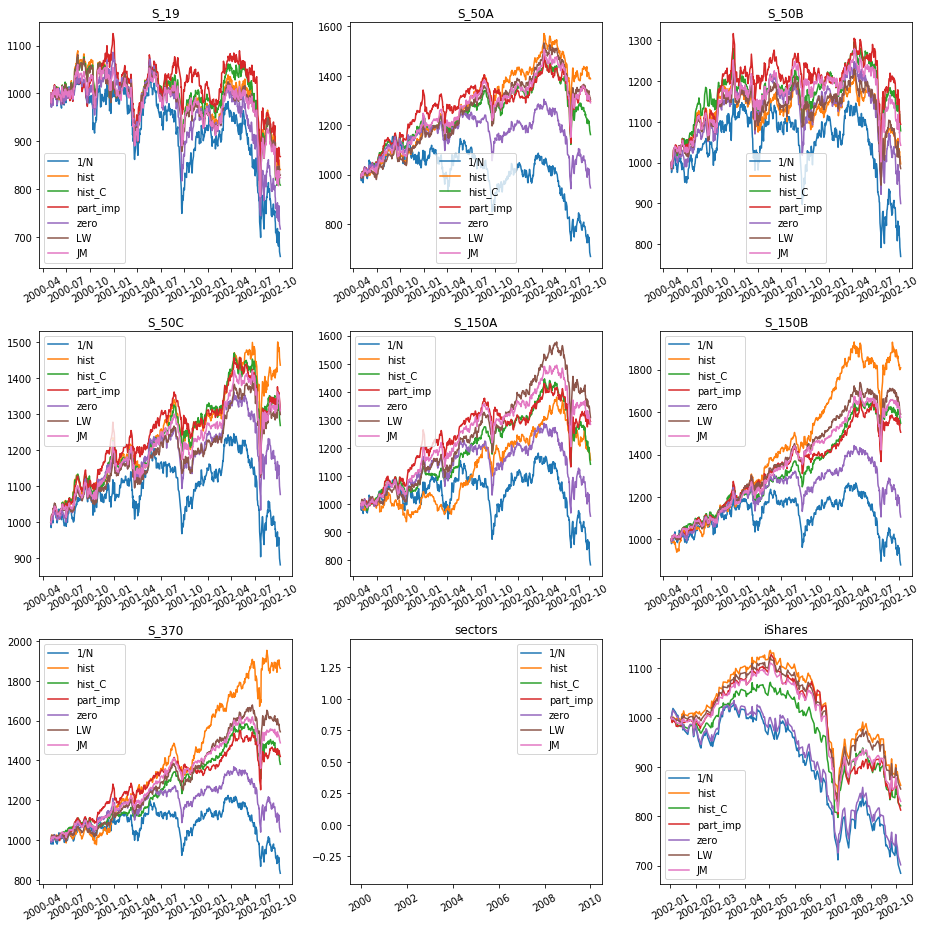

November 2002 - March 2003
--------------------------------------------------------------------------------------------------------------------------


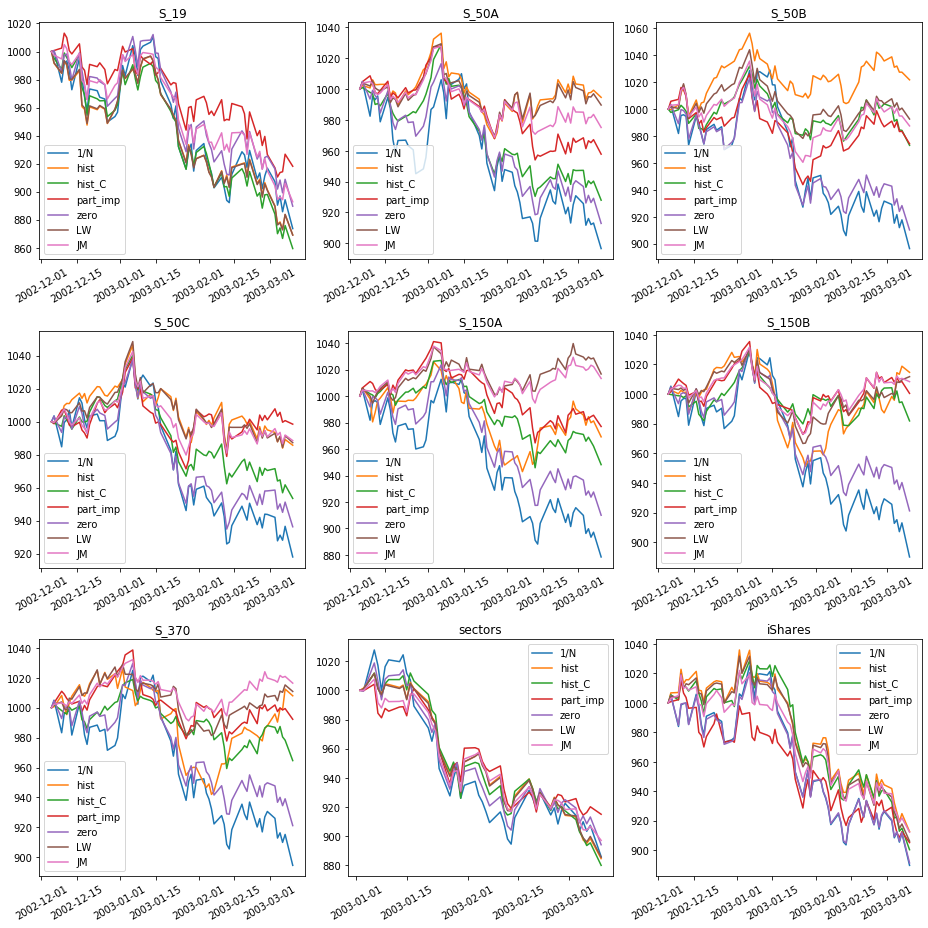

October 2007 - March 2009
--------------------------------------------------------------------------------------------------------------------------


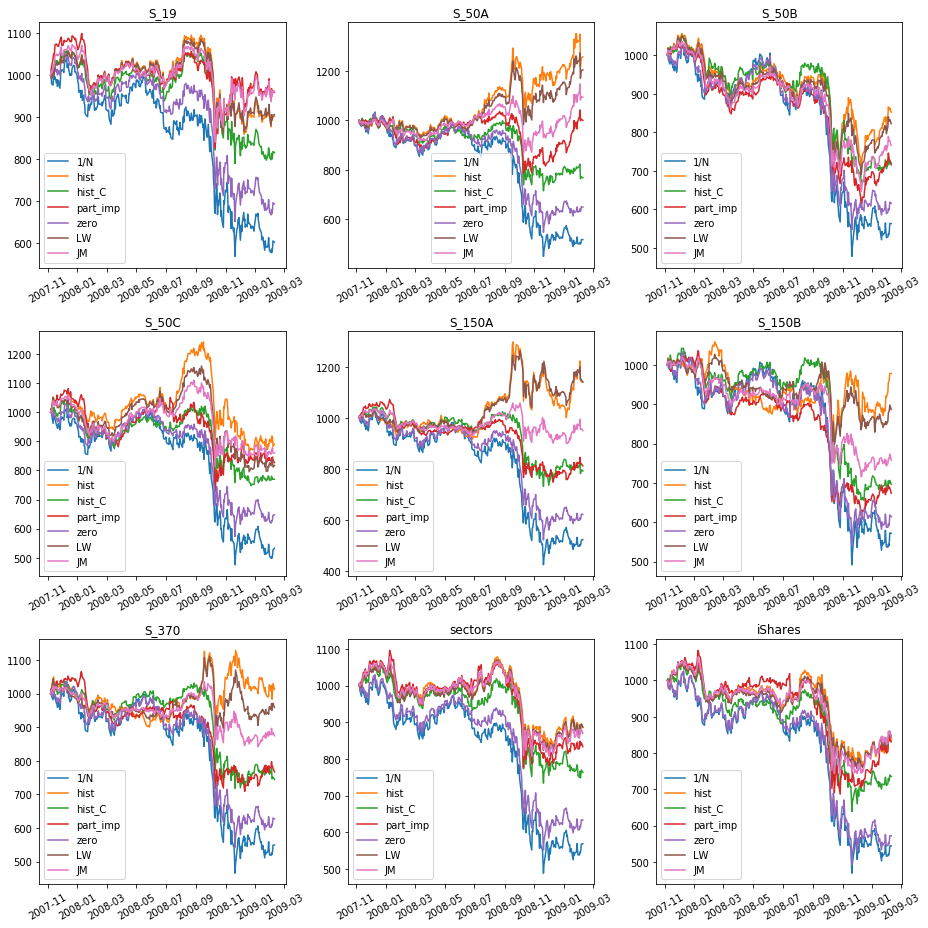

April 2010 - July 2010
--------------------------------------------------------------------------------------------------------------------------


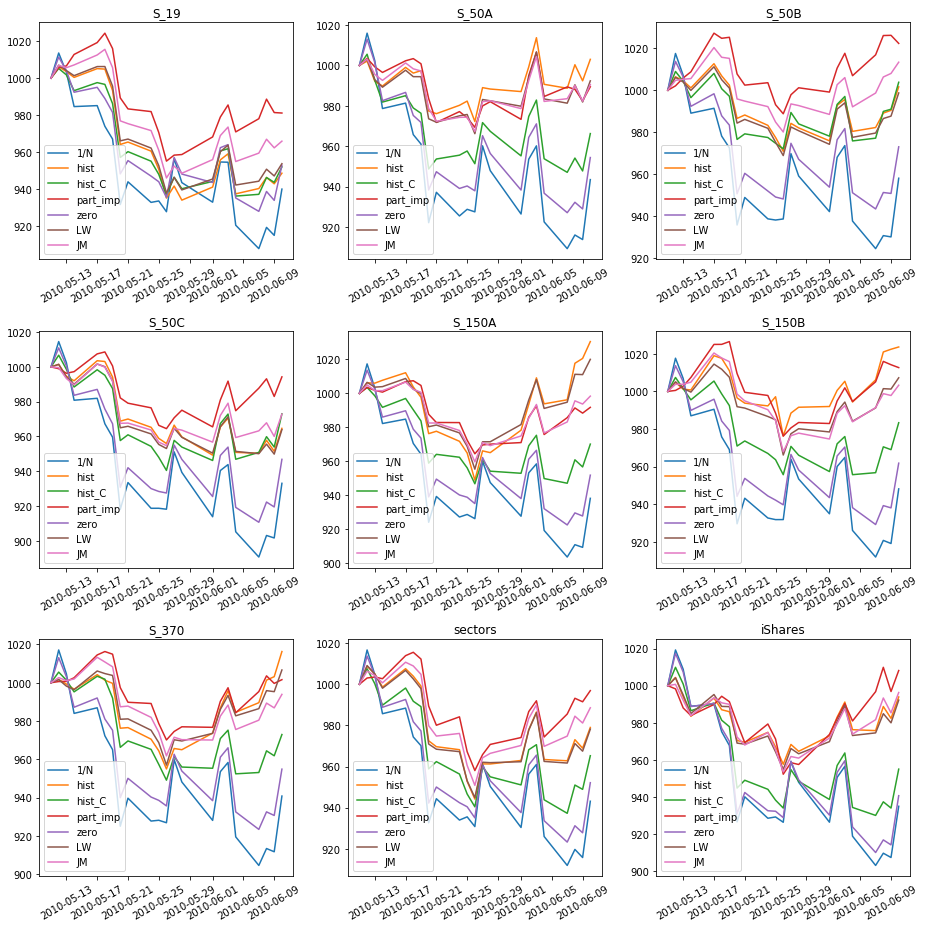

April 2011 - October 2011
--------------------------------------------------------------------------------------------------------------------------


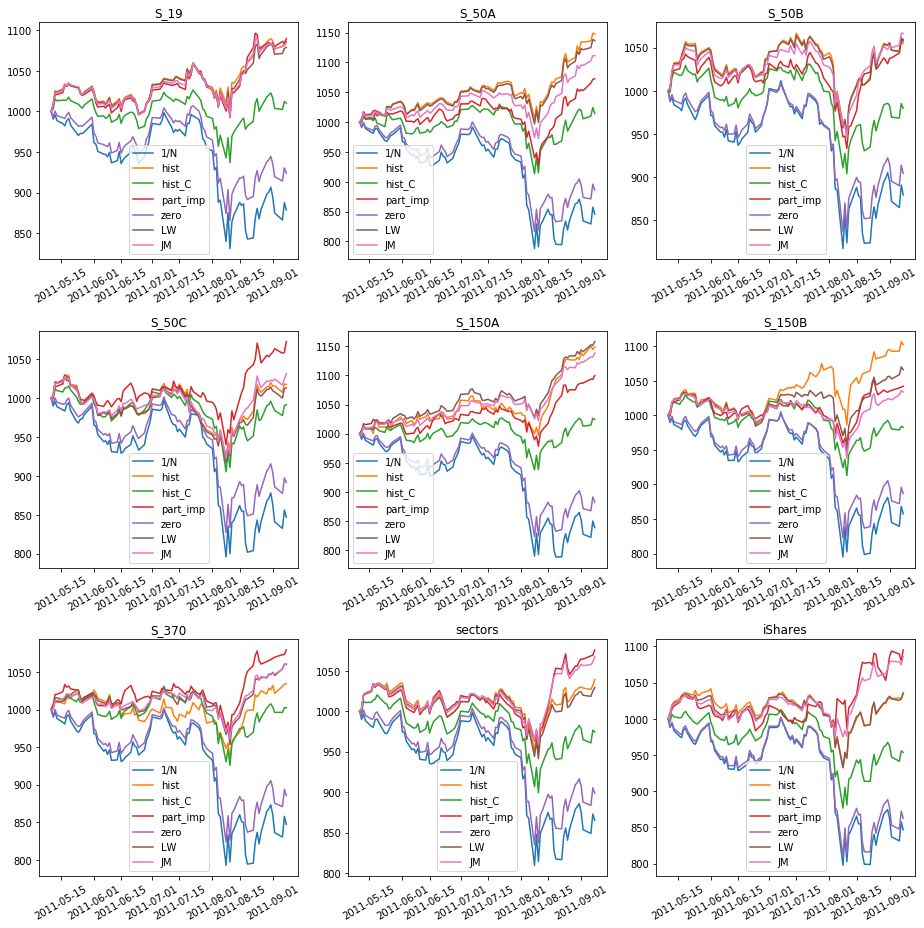

May 2015 - August 2015
--------------------------------------------------------------------------------------------------------------------------


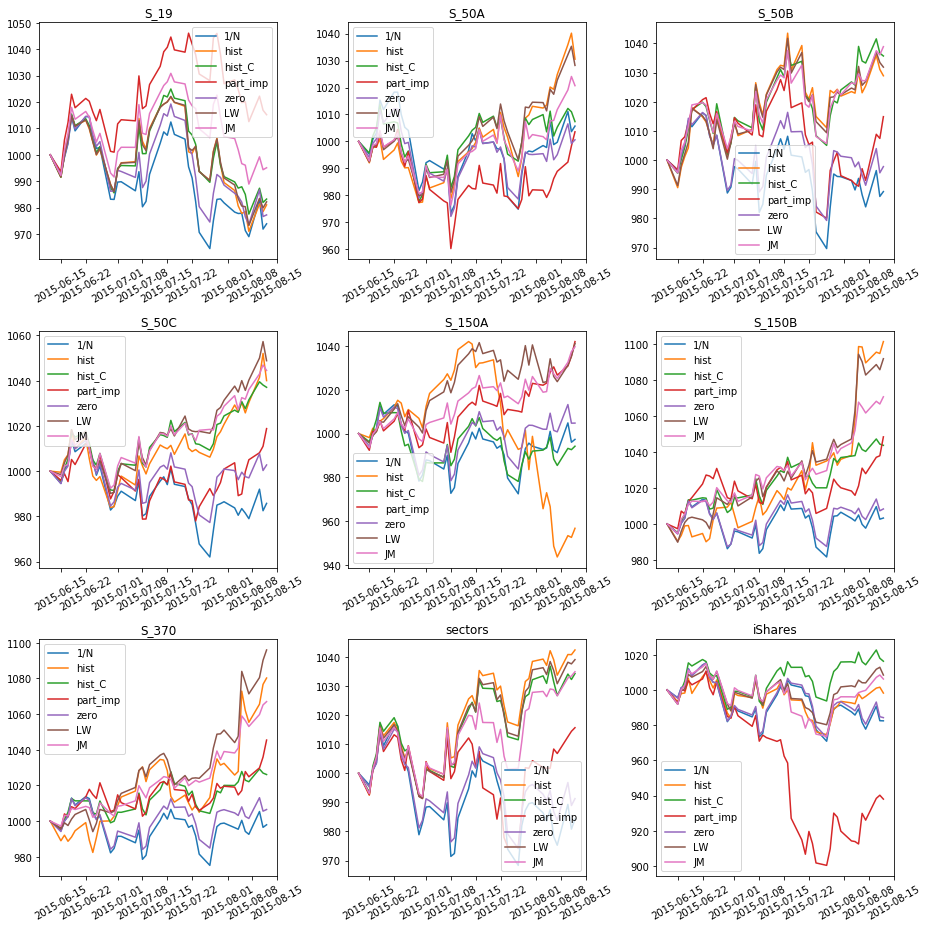

November 2015 - February 2016
--------------------------------------------------------------------------------------------------------------------------


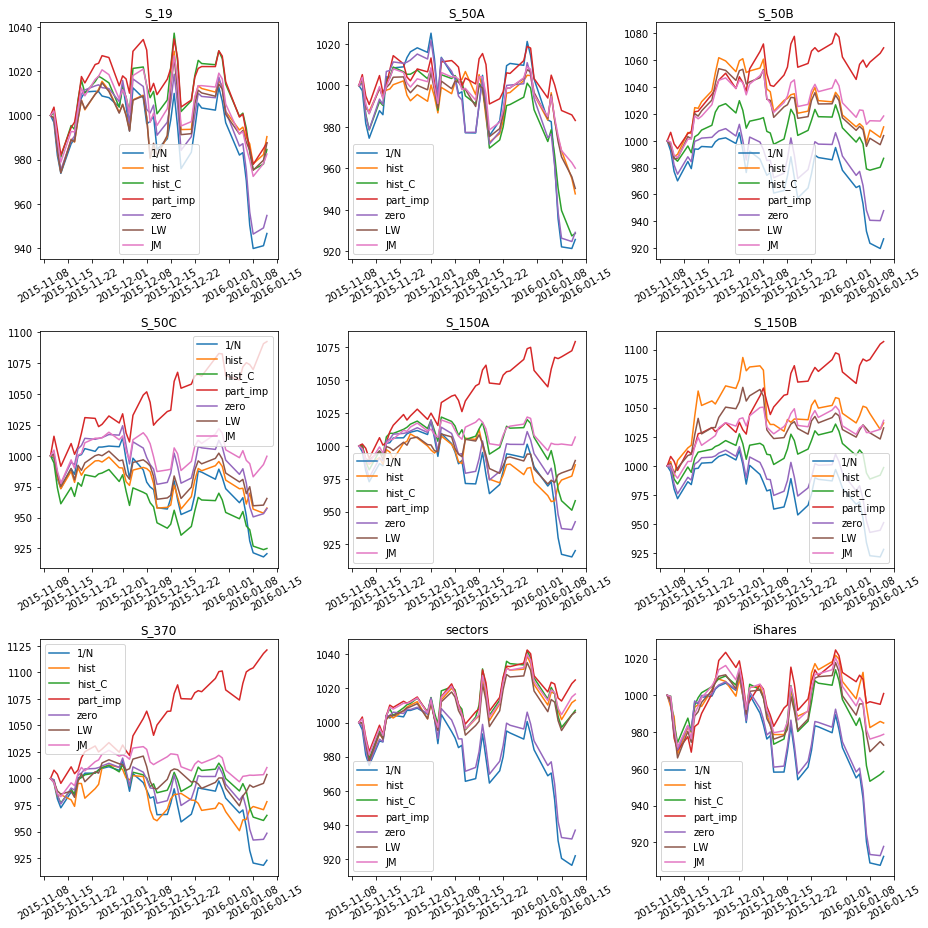

In [25]:
for i in range(0, len(bear_markets)):
    print (bear_market_names[i])
    print ("--------------------------------------------------------------------------------------------------------------------------")
    group_plot_int(port_daily, bear_markets[i][0], bear_markets[i][-1], save_as=bear_market_names[i])

In [26]:
# excluding ETF sector sample because it doesn't have data for the first crisis interval

port_daily_alt = [port_daily[0], port_daily[1], port_daily[2], port_daily[3], port_daily[4], port_daily[5], port_daily[6], port_daily[8]]

In [27]:
def group_plot_alt(port_daily, start, end, save_as, fig_size = (13, 13), titles = titles):

    plot = {}
    for i in range(len(port_daily)):        
        plottt= port_daily[i][(port_daily[i].index>=start)*(port_daily[i].index<=end)] + 1
        plottt[0:1] = 1000
        plot[i] = np.cumprod(plottt)

    fig, ax = plt.subplots(4, 2, figsize = fig_size)

    for i in range(2):
        for column in plot[i].columns:
            ax[0, i].plot(plot[i][column], label = column)
            ax[0, i].set_title(titles[i])
            ax[0, i].legend()
            plt.setp(ax[0, i].get_xticklabels(), rotation=30, horizontalalignment='center')

    for i in range(2):
        for column in plot[i+2].columns:
            ax[1, i].plot(plot[i+2][column], label = column)
            ax[1, i].set_title(titles[i+2])
            ax[1, i].legend()
            plt.setp(ax[1, i].get_xticklabels(), rotation=30, horizontalalignment='center')

    for i in range(2):
        for column in plot[i+4].columns:
            ax[2, i].plot(plot[i+4][column], label = column)
            ax[2, i].set_title(titles[i+4])
            ax[2, i].legend()
            plt.setp(ax[2, i].get_xticklabels(), rotation=30, horizontalalignment='center')
            
    for i in range(2):
        for column in plot[i+6].columns:
            ax[3, i].plot(plot[i+6][column], label = column)
            ax[3, i].set_title(titles[i+6])
            ax[3, i].legend()
            plt.setp(ax[3, i].get_xticklabels(), rotation=30, horizontalalignment='center')
    
    plt.tight_layout()
    plt.savefig(save_as)
    plt.show()

In [28]:
titles_alt = ['S_19',
 'S_50A',
 'S_50B',
 'S_50C',
 'S_150A',
 'S_150B',
 'S_370',
 'iShares']

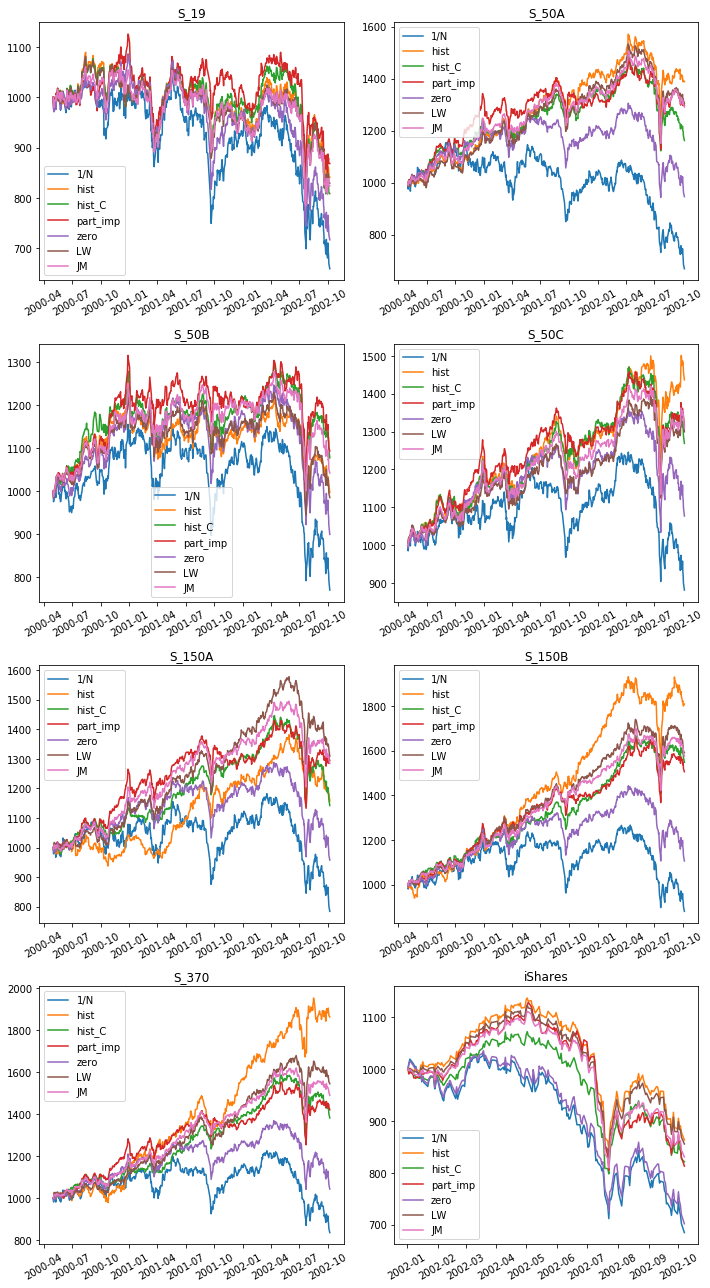

In [29]:
group_plot_alt (port_daily_alt, bear_markets[0][0], bear_markets[0][-1], save_as= 'Crisis0.png', fig_size= (10, 18), titles=titles_alt)

## Aggregate Crisis & Aggregate Non-Crisis Intervals

In [30]:
def combine (port_daily, crisis): 
    """""
    crisis - example:
    bear_markets = [crisis1, crisis2, correction1, correction2, correction3, correction4, correction5]
    """""
    
    aggregate_crisis = {}
    for i in range (len (port_daily)):
        x = [pd.concat([port_daily[i][(port_daily[i].index>=crisis[n][0])*(port_daily[i].index<=crisis[n][-1])]], axis=0) for n in range(len(crisis))]        
    
        data = []
        for z in range (len(crisis)):
            data.append(x[z])
        
        aggregate_crisis[i] = pd.concat (data)
        
        
    return aggregate_crisis

In [31]:
aggregate_crisis_R = (combine(port_daily, bear_markets))
Sharpes_crisis = summary(aggregate_crisis_R, Portfolios)[0]
print ("Panel A: Sharpe Ratio; Aggregate Crisis Intervals")
display (Sharpes_crisis.style.apply(highlight_max))
#print ('---------------------------------------------------------------------------------------')
Returns_crisis = summary(aggregate_crisis_R, Portfolios)[1]
print ("Panel B: Annualized Return (%); Aggregate Crisis Intervals")
display (Returns_crisis.style.apply(highlight_max))
#print ('---------------------------------------------------------------------------------------')
Volatilities_crisis = summary(aggregate_crisis_R, Portfolios)[2]
print ("Panel C: Annualized Volatility (%); Aggregate Crisis Intervals")
display (Volatilities_crisis.style.apply(highlight_min))

Panel A: Sharpe Ratio; Aggregate Crisis Intervals


Panel B: Annualized Return (%); Aggregate Crisis Intervals


Panel C: Annualized Volatility (%); Aggregate Crisis Intervals


In [32]:
non_crisis_R = {}
for j in range (len(aggregate_crisis_R)): 
    i=0
    non_crisis_R[j] = pd.DataFrame(columns=aggregate_crisis_R[j].columns)
    while i<len(port_daily[j]):
        if (aggregate_crisis_R[j].index == port_daily[j].index[i]).any() == False:
            non_crisis_R[j] = non_crisis_R[j].append ([port_daily[j][i:i+1]])
            i+=1
        else:
            i+=1

In [33]:
Sharpes_non_crisis = summary(non_crisis_R, Portfolios)[0]
print ("Panel A: Sharpe Ratio; Aggregate Non-Crisis Intervals")
display (Sharpes_non_crisis.style.apply(highlight_max))
#print ('---------------------------------------------------------------------------------------')
Returns_non_crisis = summary(non_crisis_R, Portfolios)[1]
print ("Panel B: Annualized Return (%); Aggregate Non-Crisis Intervals")
display (Returns_non_crisis.style.apply(highlight_max))
#print ('---------------------------------------------------------------------------------------')
Volatilities_non_crisis = summary(non_crisis_R, Portfolios)[2]
print ("Panel C: Annualized Volatility (%); Aggregate Non-Crisis Intervals")
display (Volatilities_non_crisis.style.apply(highlight_min))

Panel A: Sharpe Ratio; Aggregate Non-Crisis Intervals


Panel B: Annualized Return (%); Aggregate Non-Crisis Intervals


Panel C: Annualized Volatility (%); Aggregate Non-Crisis Intervals


In [ ]:
for i in range (len(aggregate_crisis_R)):
    aggregate_crisis_R[i].index = np.arange(len (aggregate_crisis_R[i]))

In [ ]:
group_plot(aggregate_crisis_R, 'Charts, Crisis Intervals', fig_size=(18, 13))

In [ ]:
for i in range (len(non_crisis_R)):
    non_crisis_R[i].index = np.arange(len (non_crisis_R[i]))

In [ ]:
group_plot(non_crisis_R, 'Charts, Non-Crisis Intervals', fig_size=(15, 12))

## Calculating Portfolio Beta

In [ ]:
def port_beta(data, port_daily, Portfolios):
    portfolio_beta = pd.DataFrame(index = titles, columns = Portfolios)
    for i in range(len(data)):
        x = data[i][(data[i].index>=starting_dates[i][0])*(data[i].index<starting_dates[i][-1])]["^GSPC"].values.reshape(-1, 1)
        for z in range(len(port_daily[i].columns)):
            y = port_daily[i].iloc[:, [z]].values
            model = LinearRegression()
            model.fit(x, y)            
            portfolio_beta.iloc[i:i+1, z] = model.coef_    

    return portfolio_beta

In [ ]:
portfolio_beta = port_beta(data, port_daily, Portfolios)
portfolio_beta.T.style.apply(highlight_min)

## Identifying Relationship Between VIX index and Portfolio Performance - Building Trading Strategies

In [ ]:
vix_bears = pd.concat ( [vix_daily[(vix_daily.index>=bear_markets[i][0]) * (vix_daily.index<=bear_markets[i][-1])] for i in range (len(bear_markets))] )
vix_bears.index = np.arange(len(vix_bears))

fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(vix_bears, 'r--', label = 'VIX')
ax.plot(np.ones(len(vix_bears))*20, 'y')
ax.legend()
plt.xlabel('Days')
plt.ylabel('VIX level')
plt.savefig('VIX levels during bear markets')
plt.show()
print ("We observe that VIX level bearly goes below 20 during crisis/corrections.")

### Building Combination of Minimum Variance and Naive Strategy Based on The Different Levels of VIX Index
### Net-long Investment Strategy
    first we observe vix index percentiles before 2000 (start of our sample period), and accordingly during our sample periods we define environment as:
        1. high risk (vix level above 90th percentile (25.73)), 
        2. medium risk (vix level between 40th (14.756) percentile and 90th percentile) or 
        3. low risk environment (vix level below 40th percentile).    
        
    Strategies we apply for the respective environments are:
        1. 2 long min_vol, -1 short 1/N
        2. 0.5 long min_vol, 0.5 long 1/N
        3. -1 min_vol, 2 long 1/N

In [ ]:
bins = ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
threshold_top = pd.qcut(vix_daily [vix_daily.index.year<2000], len(bins), labels = bins, retbins=True)[1][9] 
threshold_up = pd.qcut(vix_daily [vix_daily.index.year<2000], len(bins), labels = bins, retbins=True)[1][7]
threshold_medium = pd.qcut(vix_daily [vix_daily.index.year<2000], len(bins), labels = bins, retbins=True)[1][5]
threshold_down = pd.qcut(vix_daily [vix_daily.index.year<2000], len(bins), labels = bins, retbins=True)[1][4]
print ("VIX percentiles, 0 to 100:", pd.qcut(vix_daily [vix_daily.index.year<2000], len(bins), labels = bins, retbins=True)[1])

In [ ]:
def trigger_points(thresholds, criteria, port_daily, portfolio1, portfolio2, port_weight):

    analysis = port_daily.copy()
    analysis["Criteria"] = (criteria[(criteria.index>=analysis.index[0])*(criteria.index<=analysis.index[-1])])
    analysis['Mix1'] = analysis['1/N'].copy()    
    

    #extreme risk
    condition0 = (analysis['Criteria']>thresholds[2])
    analysis['Mix1'] [condition0] = port_weight[0][0] * analysis[portfolio1][condition0] + port_weight[0][1] * analysis[portfolio2][condition0]

    #high risk
    condition1 = (analysis['Criteria']<=thresholds[2]) * (analysis['Criteria']>=thresholds[1])
    analysis['Mix1'] [condition1] = port_weight[1][0] * analysis[portfolio1][condition1] + port_weight[1][1] * analysis[portfolio2][condition1]

    #medium risk
    condition2 = (analysis['Criteria']<thresholds[1]) * (analysis['Criteria']>thresholds[0])
    analysis['Mix1'][condition2] = port_weight[2][0] * analysis[portfolio1][condition2] + port_weight[2][1] * analysis[portfolio2][condition2]

    #low risk
    condition3 = (analysis['Criteria']<=thresholds[0])
    analysis['Mix1'] [condition3] =  port_weight[3][0] * analysis[portfolio1][condition3] + port_weight[3][1] * analysis[portfolio2][condition3]

    return analysis['Mix1']

port_weight = [(2, -1), (0.5, 0.5), (0.5, 0.5), (-1, 2)]

hist_mix1 = {}
part_imp_mix1 = {}
JM_mix1 = {}

for i in range (len(port_daily)):
    hist_mix1[i] = trigger_points([threshold_down, threshold_up, threshold_top], vix_daily, port_daily[i], 'hist', '1/N', port_weight)
    part_imp_mix1[i] = trigger_points([threshold_down, threshold_up, threshold_top], vix_daily, port_daily[i], 'part_imp', '1/N', port_weight)
    JM_mix1[i] = trigger_points([threshold_down, threshold_up, threshold_top], vix_daily, port_daily[i], 'JM', '1/N', port_weight)

In [ ]:
threshold_down, threshold_up, threshold_top

In [ ]:
port_daily_new = {}
for i in range(len(port_daily)):
    port_daily_new[i] = port_daily[i].copy()
    port_daily_new[i]['hist_mix'] = hist_mix1[i]
    #port_daily_new[i]['part_imp_mix1'] = part_imp_mix1[i]
    port_daily_new[i]['JM_mix'] = JM_mix1[i]
    
Portfolios_new = ['1/N', 'hist', 'hist_C', 'part_imp', 'zero', 'LW', 'JM', 'hist_mix', 'JM_mix']

Sharpes_new = summary(port_daily_new, Portfolios_new)[0]
Returns_new = summary(port_daily_new, Portfolios_new)[1]
Volatilities_new = summary(port_daily_new, Portfolios_new)[2]

print ("Panel A: Sharpe Ratio; Whole Period")
display (Sharpes_new.style.apply(highlight_max))
#print ('---------------------------------------------------------------------------------------')
print ("Panel B: Annualized Return (%); Whole Period")
display (Returns_new.style.apply(highlight_max))
#print ('---------------------------------------------------------------------------------------')
print('Panel C: Annualized Volatility (%); Whole Period')
display (Volatilities_new.style.apply(highlight_min))
group_plot (port_daily_new, 'Charts, Whole Period; New Strategies')

## Comparing The Performance of Our Lowest Volatility to iShares Minimum Volatility ETF (under management more than $30 bill)

In [ ]:
stock = ['USMV']
start = dt.datetime (2009, 1, 1)
end = dt.datetime (2020, 4, 13)  
ETF_min_v = pdr.yahoo.daily.YahooDailyReader (stock, start, end, interval='d').read()
ETF_min_v = ETF_min_v['Adj Close']
ETF_min_v_return = (np.log(ETF_min_v) - np.log(ETF_min_v.shift(1)))
JM_370_return = port_daily[6]['JM']
JM_comparison = JM_370_return[JM_370_return.index.year>2011]
USMV = ETF_min_v_return[(ETF_min_v_return.index.year>2011) * (ETF_min_v_return.index <= JM_comparison.index[-1])]

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(JM_comparison, 'm', label = "JM")
ax.plot(USMV, "powderblue", label = "USMV")

ax.legend()
plt.ylabel('Daily Return')
plt.savefig("ETF_min_v_comparison.png")
plt.show()

USMV_vol = float((USMV).std()*np.sqrt(252)*100)
USMV_ret = float((USMV).mean()*252*100)

print ("USMV volatility:", round(USMV_vol, 2))
print ("USMV return:", round(USMV_ret, 2))
print ("USMV Sharpe:", round(USMV_ret/USMV_vol, 2))

JM_vol = JM_comparison.std()*np.sqrt(252)*100
JM_ret = JM_comparison.mean()*252*100

print ("JM volatility:", round(JM_vol, 2))
print ("JM return:", round (JM_ret, 2))
print ("JM Sharpe:", round (JM_ret/JM_vol, 2))

In [ ]:
plot_USMV = USMV + 1
plot_USMV[0:1] = 1000
plot_USMV = np.cumprod(plot_USMV)

plot_JM = JM_comparison + 1
plot_JM[0:1] = 1000
plot_JM = np.cumprod(plot_JM)

fig, ax = plt.subplots (figsize = (12, 5))
ax.plot(plot_USMV, 'powderblue', label = "USMV")
ax.plot(plot_JM, "m", label = "JM")
ax.legend()
plt.ylabel("Portfolio Value")
plt.savefig("USMV & JM return.png")
plt.show()

## Exporting Results to Excel

In [42]:
writer = pd.ExcelWriter ('results.xlsx', engine='xlsxwriter')
workbook = writer.book

row = 0
Sharpes.to_excel (writer, sheet_name = "Whole Period", startrow = row, startcol = 0)
row+=(len(Portfolios)+2)
Returns.to_excel (writer, sheet_name = "Whole Period", startrow = row, startcol = 0)
row+=(len(Portfolios)+2)
Volatilities.to_excel (writer, sheet_name = "Whole Period", startrow = row, startcol = 0)        

row = 0
for i in range(len(crisis_Sharpe)):
    crisis_Sharpe[i].to_excel (writer, sheet_name = "Crisis_Sh", startrow = row, startcol = 0)
    row+=(len(Portfolios)+2)

row = 0
Sharpes_crisis.to_excel (writer, sheet_name = "Agg_Crisis", startrow = row, startcol = 0)
row+=(len(Portfolios)+2)
Returns_crisis.to_excel (writer, sheet_name = "Agg_Crisis", startrow = row, startcol = 0)
row+=(len(Portfolios)+2)
Volatilities_crisis.to_excel (writer, sheet_name = "Agg_Crisis", startrow = row, startcol = 0)

row = 0
Sharpes_non_crisis.to_excel (writer, sheet_name = "Agg_Non_Crisis", startrow = row, startcol = 0)
row+=(len(Portfolios)+2)
Returns_non_crisis.to_excel (writer, sheet_name = "Agg_Non_Crisis", startrow = row, startcol = 0)
row+=(len(Portfolios)+2)
Volatilities_non_crisis.to_excel (writer, sheet_name = "Agg_Non_Crisis", startrow = row, startcol = 0)

portfolio_beta.T.to_excel (writer, sheet_name = "Port_beta", startrow = 0, startcol = 0)

row = 0
Sharpes_new.to_excel (writer, sheet_name = "Hybrid", startrow = row, startcol = 0)
row+=(len(Portfolios_new)+2)
Returns_new.to_excel (writer, sheet_name = "Hybrid", startrow = row, startcol = 0)
row+=(len(Portfolios_new)+2)
Volatilities_new.to_excel (writer, sheet_name = "Hybrid", startrow = row, startcol = 0)        


writer.save()

In [44]:
writer = pd.ExcelWriter ('crisis_uncombined.xlsx', engine='xlsxwriter')
workbook = writer.book

row = 0
for i in range(len(crisis_Return)):
    crisis_Return[i].to_excel (writer, sheet_name = "Crisis", startrow = row, startcol = 0)
    crisis_Vol[i].to_excel (writer, sheet_name = "Crisis", startrow = row, startcol = 9)
    row+=(len(Portfolios)+2)


writer.save()

In [194]:
writer = pd.ExcelWriter ('results_crisis.xlsx', engine='xlsxwriter')
workbook = writer.book

row = 0
for i in range(len(bear_market_names)):
    (test[i][0]).to_excel (writer, sheet_name = "{}".format(bear_market_names[i], startrow = row, startcol = 0))


writer.save()

## PORTFOLIOS INCORPORATING MOMENTUM

In [269]:
Portfolios_M = ['0.5', '0.7', '0.9', 'pure_momentum'] #, 'pure_momentum', 'momentum_alt'] also have to adjust sample 370
pickle_in = open('momentum.pickle', 'rb')
w_momentum = pickle.load(pickle_in)
pickle_in = open('sample370M.pickle', 'rb')
sample370M = pickle.load(pickle_in)


w_0 = {}
w_1 = {}
w_2 = {}
w_3 = {}
w_4 = {}
w_5 = {}
w_etf1 = {}
w_etf2 = {}

for i in range(len(Portfolios_M)):
    w_0[i] = w_momentum[i][0]
    w_1[i] = w_momentum[i][1]
    w_2[i] = w_momentum[i][2]
    w_3[i] = w_momentum[i][3]
    w_4[i] = w_momentum[i][4]
    w_5[i] = w_momentum[i][5]
    w_etf1[i] = w_momentum[i][6]
    w_etf2[i] = w_momentum[i][7]
    
w = [w_0, w_1, w_2, w_3, w_4, w_5, sample370M, w_etf1, w_etf2]
weights_M = {}
for i in range(len(w)):
    weights_M[i] = w[i]

In [273]:
res = {}
for i in range (len(data)):
    res[i] = summary_log(weights_M[i], Portfolios_M, starting_dates[i], data[i])

In [277]:
momentum_vol = {}
for i in range (len(res)):
    momentum_vol[i] = res[i][2]

In [270]:
port_daily_M = {}
for i in range (len(data)):
    port_daily_M[i] = backtest(weights_M[i], Portfolios_M, data[i], starting_dates[i])

In [271]:
Sharpes_momentum = summary(port_daily_M, Portfolios_M)[0]
Returns_momentum = summary(port_daily_M, Portfolios_M)[1]
Vol_momentum = summary(port_daily_M, Portfolios_M)[2]

print ("SHARPE RATIO")
display (Sharpes_momentum.style.apply(highlight_max))
print ('----------------------------------------------------------------')
print ("RETURN")
display (Returns_momentum.style.apply(highlight_max))
print ('----------------------------------------------------------------')
print ('VOLATILITY')
display (Vol_momentum.style.apply(highlight_min))

SHARPE RATIO


----------------------------------------------------------------
RETURN


----------------------------------------------------------------
VOLATILITY


### FURTHER CONSIDERATIONS

In [ ]:
def summary_log (weights, Portfolios, intervals, df_CCR):
    """""
    input example: weights = [weights_1, weights_2, weights_3]
    
    """""
    
    out_of_sample = {}
    for number in (0, intervals):
        out_of_sample[number] = pd.DataFrame
    
    port_volatility = pd.DataFrame(index=starting_dates[:-1], columns=Portfolios)
    port_return_annual = pd.DataFrame(index=starting_dates[:-1], columns=Portfolios)
    SharpeRatio = pd.DataFrame(index=starting_dates[:-1], columns=Portfolios)
    

    for i in range(intervals):
        
        out_of_sample[i] = df_CCR[(df_CCR.index>=starting_dates[i]) * (df_CCR.index<=starting_dates[i+1])][df_CCR.columns[:-1]]
        
        for n in range (len(weights)):
            cov_daily = out_of_sample[i].astype(float).cov()
            cov_annual = cov_daily * 252
            port_variance = np.dot(weights[n][i].T, np.dot(cov_annual, weights[n][i]))
            port_volatility.iloc[[i], [n]] = np.sqrt(port_variance)
            monthly_returns = np.asarray (np.sum(out_of_sample[i]))
            port_return = monthly_returns @ np.asarray(weights[n][i])
            port_return_annual.iloc[[i], [n]] = port_return * 12
            SharpeRatio.iloc[[i], [n]] = port_return_annual.iloc[[i], [n]]/port_volatility.iloc[[i], [n]]
                    
    
    return SharpeRatio, port_return_annual, port_volatility

In [ ]:
Returns_alt = pd.DataFrame (index = Portfolios, columns = ['s19', 's50', 's50A', 's50B', 's150', 's150A'])
for i in range (len(res)):
    Returns_alt.iloc[:, [i]] = np.asarray (res[i][1].mean()).reshape(len(Portfolios), 1)
    
(Returns_alt*100).style.apply(highlight_max)

In [ ]:
Returns.style.apply(highlight_max)